In [1]:
%matplotlib inline
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from agent import model
from agent import dhp as DHP

In [2]:
def reference_state(current_state):
    y_pos = current_state[1]
    if y_pos > 0.75:
        ref_state = [0, 0, 0, -0.25, 0, 0, 0, 0]
    else:
        ref_state = [0, 0, 0, -0.1, 0, 0, 0, 0]
    return ref_state

# Example of Controlling LunarLander v2
Observation space:
[x, y, V_x, V_y, angle, angular velocity, left leg contact, right leg contact]

In [3]:
env = gym.make(
    "LunarLander-v2", continuous = True
)
init_condition = env.reset()
state_size = len(init_condition)
action_size = int(env.action_space.shape[0])

X, U, R, errors = [], [], [], []
t0 = 0
tn = 30
dt = 0.01
t = np.arange(t0, tn, dt)

# run single episode
for i in range(1,len(t)):
    action = [0.1,-0.6]
    state, reward, done, _, _= env.step(action)
    X.append(state)
    U.append(action)
    R.append(reward)
    errors.append(np.abs(state - reference_state(state)))
    env.render()
    if done: 
        t = t[:i]
        break
action_size

c:\Users\Labra\miniconda3\envs\tf_GPU\lib\site-packages\gymnasium\envs\box2d\lunar_lander.py:681: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


2

## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


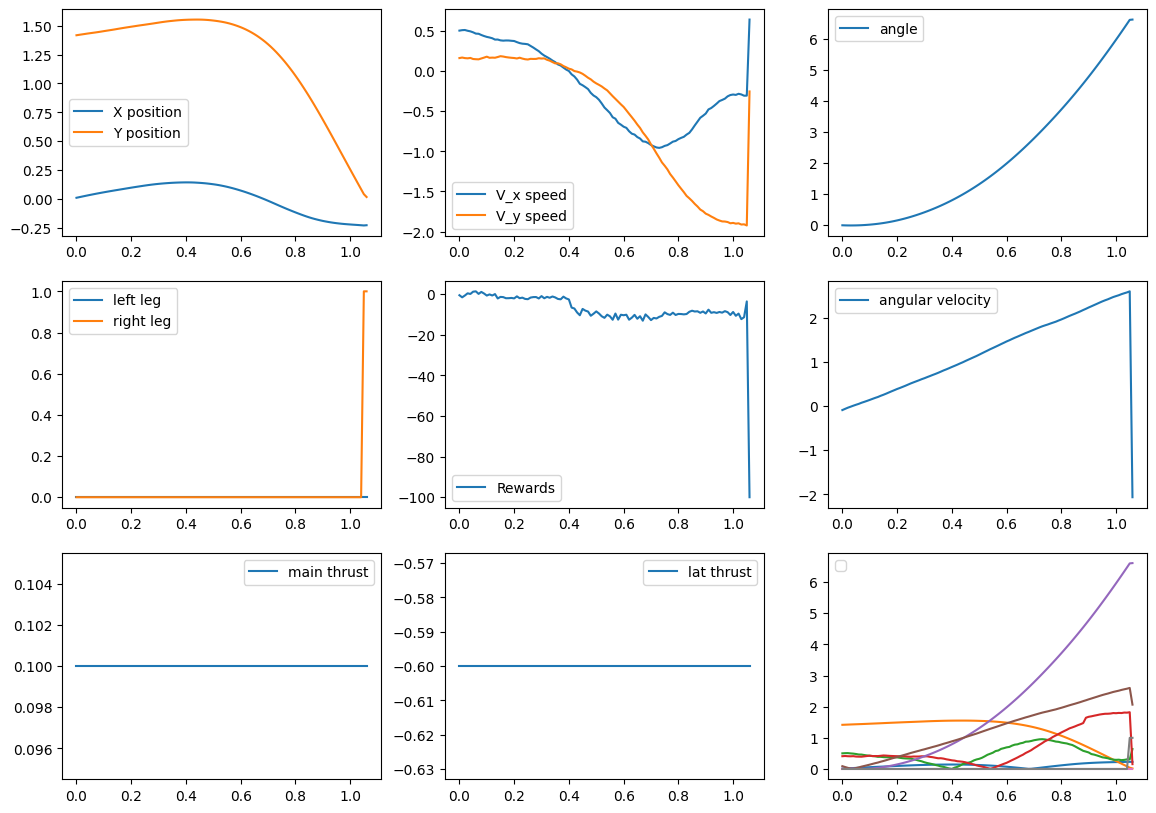

In [4]:
fig, axis = plt.subplots(3,3, figsize=(14,10))
axis[0, 0].plot(t, [i[0] for i in X], label="X position")
axis[0, 0].plot(t, [i[1] for i in X], label="Y position")
axis[0, 0].legend()

axis[0, 1].plot(t, [i[2] for i in X], label="V_x speed")
axis[0, 1].plot(t, [i[3] for i in X], label="V_y speed")
axis[0, 1].legend()

axis[0,2].plot(t, [i[4] for i in X], label="angle")
axis[0,2].legend()

axis[1,2].plot(t, [i[5] for i in X], label="angular velocity")
axis[1,2].legend()

axis[1,0].plot(t, [i[6] for i in X], label="left leg")
axis[1,0].plot(t, [i[7] for i in X], label="right leg")
axis[1,0].legend()

axis[1,1].plot(t, R, label="Rewards")
axis[1,1].legend()

axis[2,0].plot(t, [i[0] for i in U], label="main thrust")
axis[2,0].legend()
axis[2,1].plot(t, [i[1] for i in U], label="lat thrust")
axis[2,1].legend()

axis[2,2].plot(t, errors)
axis[2,2].legend()


# DHP LunarLander

In [5]:
TENSORBOARD_DIR = './logs/tensorboard/DHP/'

env = gym.make(
    "LunarLander-v2", continuous = True
)
init_condition = env.reset()[0]
state_size = len(init_condition)
action_size = int(env.action_space.shape[0])
TRACKED = [True for i in init_condition]
STATE_ERROR_WEIGHTS = [0, 0, 100, 100, 10, 25, 0, 0]

t0 = 0
tn = 30
dt = 0.01
t = np.arange(t0, tn, dt)

ac_kwargs = {
        # Arguments for all model types
        'state_size': state_size,
        'action_size': action_size,
        'predict_delta': False,
        # Neural Network specific args:
        'hidden_layer_size': [100, 100, 100],
        'activation': tf.nn.relu,
        # RLS specific args:
        'gamma': 0.9998,
        'covariance': 100,
        'constant': True,
        # LS specific args:
        'buffer_length': 10
}
ac_model = model.RecursiveLeastSquares(**ac_kwargs)

lr_critic = 0.1
lr_actor = 0.09
kwargs = {
    'input_size': [state_size, state_size],                     # [Aircraft state size, Number of tracked states]
    'output_size': action_size,                                         # Actor output size (Critic output is dependend only on aircraft state size)
    'hidden_layer_size': [50, 50, 50],                                    # List with number of nodes per layer, number of layers is variable
    'kernel_stddev': 0.1,                                               # Standard deviation used in the truncated normal distribution to initialize all parameters
    'lr_critic': lr_critic,                                                   # Learn rate Critic
    'lr_actor': lr_actor,                                                   # Learn rate Actor
    'gamma': 0.4,                                                       # Discount factor
    'use_bias': False,                                                  # Use bias terms (only if you train using batched data)
    'split': False,                                                      # Split architechture of the actor, if False, a single fully connected layer is used.
    'target_network': False,                                             # Use target networks 
    'tau': 0.001,                                                       # Target network time constant 
    'activation': tf.keras.layers.Activation('relu'),
    'log_dir': TENSORBOARD_DIR,                                         # Where to save checkpoints
    'use_delta': (False, TRACKED)                                       # (True, TRACKED) used 's = [x, (x - x_ref)]' || (False, None) uses 's = [x, x_ref]' 
}
agent = DHP.Agent(**kwargs) 
# todo continue actor and critic breakdown

d:\Documents\Lab\Python\RL\simple-A2C-PPO-practice\agent\dhp.py:138: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.compat.v1.layers.dense(
c:\Users\Labra\miniconda3\envs\tf_GPU\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
d:\Documents\Lab\Python\RL\simple-A2C-PPO-practice\agent\dhp.py:144: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.output_critic = tf.compat.v1.layers.dense(
d:\Documents\Lab\Python\RL\simple-A2C-PPO-practice\agent\dhp.py:255: UserWarning: `tf.layers.dense` is dep

Critic Network build.
Actor network build.


In [8]:
X, U, R, list_C = [], [], [], []
X_pred, C_trained, action_grad, critic_grad = [], [], [], [] 
list_F, list_G, list_RLS_cov, e_model = [], [], [], []
U_ref = []
episode_counter = 0
max_episode = 10 
with tqdm(range(max_episode)) as tqdm_it:
    for i in tqdm_it:
        print(f"iter: {i}")
        # init params 
        init_condition = env.reset()[0]
        ac_model.reset()
        ac_model.reset_covariance()
        x = init_condition.reshape([1, -1, 1])
        x_ref = reference_state(init_condition)
        P = np.diag(TRACKED).astype(float)
        Q = np.diag(STATE_ERROR_WEIGHTS)
        X.append(init_condition)
        done = False
        while not done:
            R_sig = np.array(reference_state(np.squeeze(x))).reshape([1, -1, 1])
            U_ref.append(R_sig)
            j = 1
            while j < 2: 
                # Next state prediction
                action = np.squeeze(agent.action(x, reference = R_sig))
                action_clipped = np.clip(action, np.array([0, -1]), np.array([1, 1]))
                x_next_pred = ac_model.predict(x, action_clipped).reshape([1, -1, 1])

                # Cost prediction
                e = np.matmul(P, x_next_pred - R_sig) 
                cost = np.matmul(np.matmul(e.transpose(0,2,1), Q), e)
                dcostdx = np.matmul(2*np.matmul(e.transpose(0,2,1), Q), P)
                
                # Critic
                dactiondx       = agent.gradient_actor(x, reference = R_sig)
                lmbda           = agent.value_derivative(x, reference = R_sig)
                target_lmbda    = agent.target_value_derivative(x_next_pred, reference = R_sig)
                A               = ac_model.gradient_state(x, action_clipped)
                B               = ac_model.gradient_action(x, action_clipped)

                if np.isnan(A).any():
                    done = True
                    print("="*8, j, "="*8)
                    print(f"{x = }, {x_next_pred = }")
                    print(f"{action_clipped =}\n{x =}\n{R_sig =}")
                    print(f"{dcostdx = }, {agent.gamma =}, {target_lmbda = }, {A =}, {B =}")
                    print(f"{dactiondx = }")
                    print(f"{grad_actor = }\n{grad_critic = }")
                    print("="*20)
                    episode_counter += 1

                j += 1
                grad_critic     = lmbda - np.matmul(dcostdx + agent.gamma*target_lmbda, A + np.matmul(B, dactiondx))            
                grad_critic     = np.clip(grad_critic, -0.4, 0.4)
                agent.update_critic(x, reference = R_sig, gradient = grad_critic, learn_rate=lr_critic)

                # Actor
                lmbda       = agent.value_derivative(x_next_pred, reference = R_sig)
                grad_actor  = np.matmul(dcostdx + agent.gamma*lmbda, B)
                grad_actor  = np.clip(grad_actor, -2.0, 2.0)
                # grad_actor  = utils.overactuation_gradient_correction(gradients=grad_actor, actions=action, actions_clipped=action_clipped)
                agent.update_actor(x, reference = R_sig, gradient = grad_actor, learn_rate=lr_actor)
            X_pred.append(x_next_pred)
            C_trained.append(cost.flatten())
            action_grad.append(grad_actor)
            critic_grad.append(grad_critic)
            list_F.append(A.flatten().copy())
            list_G.append(B.flatten().copy())
            list_RLS_cov.append(ac_model.cov.copy())

            ### Run environment ###
            action      = agent.action(x, reference = R_sig)
            action = np.clip(action, np.array([0, -1]), np.array([1, 1]))
    #        if i < 1000: # TODO: take some contrained controls 
    #            action += excitation[:,i].reshape(action.shape)
            x_next, reward, _, _, _ = env.step(np.squeeze(action))
            R.append(reward)
            model_error = ((x_next_pred - x_next)**2).mean()
            X.append(x_next)
            U.append(np.squeeze(action))
            e_model.append(model_error)

            ### Real Cost ###
            e = np.matmul(P, (x_next - x_ref))
            cost = np.matmul(np.matmul(e, Q), e)
            list_C.append(cost)

            ### Update Model ###
       #     print(f" in model UPDATE {action = }")
            ac_model.update(x, action, x_next)

            ### Bookkeeping ###
            x = x_next.reshape([1, -1, 1])
            if x_next[-1] or x_next[-2]: # break loop when legs are touching ground  
                done = True
                episode_counter += 1
                print("DONE")

 40%|████      | 4/10 [00:00<00:00, 33.06it/s]

iter: 0
======== 1 ========
x = array([[[ 0.01501322],
        [ 1.4302719 ],
        [ 0.7592796 ],
        [ 0.41713044],
        [-0.01720131],
        [-0.17021419],
        [ 0.        ],
        [ 0.        ]]], dtype=float32), x_next_pred = array([[[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]]])
action_clipped =array([nan, nan])
x =array([[[ 0.01501322],
        [ 1.4302719 ],
        [ 0.7592796 ],
        [ 0.41713044],
        [-0.01720131],
        [-0.17021419],
        [ 0.        ],
        [ 0.        ]]], dtype=float32)
R_sig =array([[[ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [-0.25],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ]]])
dcostdx = array([[[nan, nan, nan, nan, nan, nan, nan, nan]]]), agent.gamma =0.4, target_lmbda = array([[[nan, nan, nan, nan, nan, nan, nan, nan]]], dtype=float32), A =array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan

100%|██████████| 10/10 [00:00<00:00, 31.15it/s]

iter: 7
======== 1 ========
x = array([[[ 0.00988169],
        [ 1.3884317 ],
        [ 0.499758  ],
        [-0.51257867],
        [-0.01131992],
        [-0.11204129],
        [ 0.        ],
        [ 0.        ]]], dtype=float32), x_next_pred = array([[[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]]])
action_clipped =array([nan, nan])
x =array([[[ 0.00988169],
        [ 1.3884317 ],
        [ 0.499758  ],
        [-0.51257867],
        [-0.01131992],
        [-0.11204129],
        [ 0.        ],
        [ 0.        ]]], dtype=float32)
R_sig =array([[[ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [-0.25],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ],
        [ 0.  ]]])
dcostdx = array([[[nan, nan, nan, nan, nan, nan, nan, nan]]]), agent.gamma =0.4, target_lmbda = array([[[nan, nan, nan, nan, nan, nan, nan, nan]]], dtype=float32), A =array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan

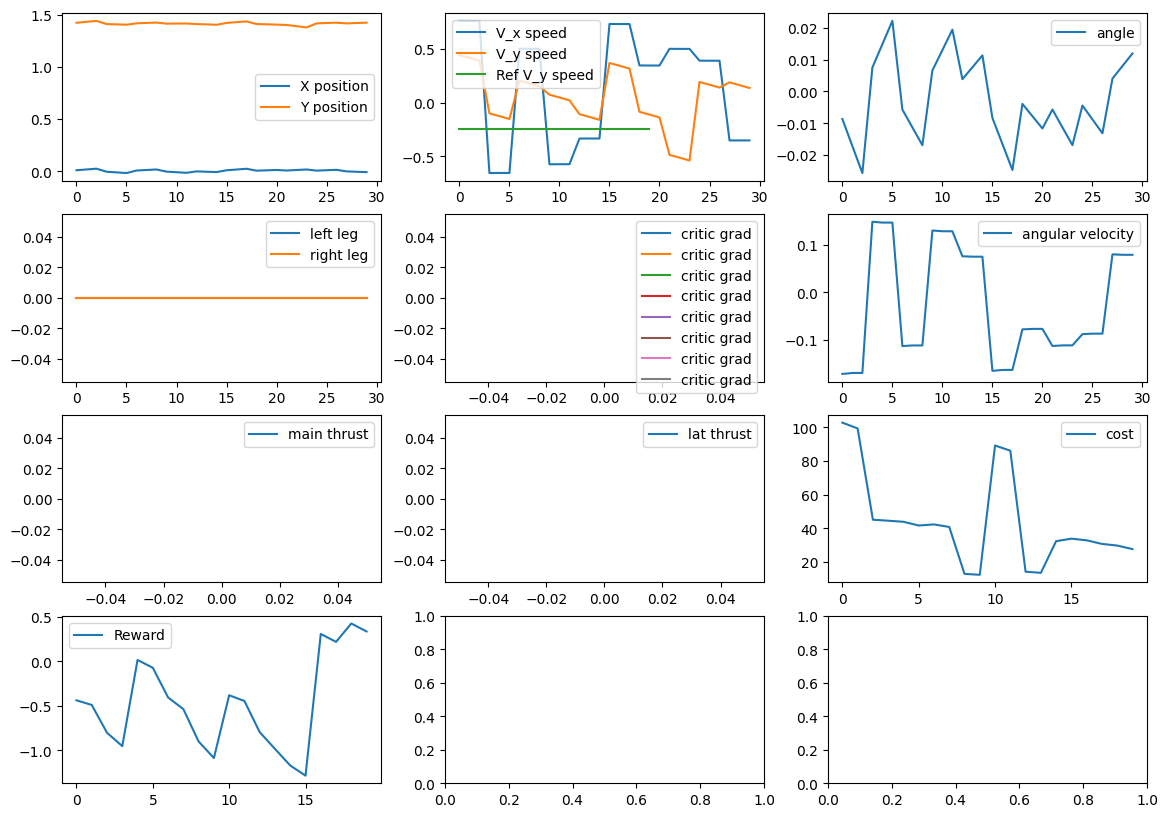

In [9]:
fig, axis = plt.subplots(4,3, figsize=(14,10))
axis[0, 0].plot([i[0] for i in X], label="X position")
axis[0, 0].plot([i[1] for i in X], label="Y position")
axis[0, 0].legend()

axis[0, 1].plot([i[2] for i in X], label="V_x speed")
axis[0, 1].plot([i[3] for i in X], label="V_y speed")
axis[0, 1].plot([np.squeeze(i)[3] for i in U_ref], label="Ref V_y speed")
axis[0, 1].legend()

axis[1, 1].plot([np.squeeze(i) for i in critic_grad], label="critic grad")
axis[1, 1].legend()


axis[0,2].plot([i[4] for i in X], label="angle")
axis[0,2].legend()

axis[1,2].plot([i[5] for i in X], label="angular velocity")
axis[1,2].legend()

axis[1,0].plot([i[6] for i in X], label="left leg")
axis[1,0].plot([i[7] for i in X], label="right leg")
axis[1,0].legend()

axis[2,0].plot([i[0] for i in U], label="main thrust")
axis[2,0].legend()
axis[2,1].plot([i[1] for i in U], label="lat thrust")
axis[2,1].legend()

axis[2,2].plot(list_C, label="cost")
axis[2,2].legend()

axis[3,0].plot(R, label="Reward")
axis[3,0].legend()